In [138]:
import xml.etree.ElementTree
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
%run utils/utilities.py

In [139]:
DATASET_ROOT = './datasets/PTIT'
DATASET_NORM = DATASET_ROOT + '/normalized'
DATASET_TRAIN = DATASET_NORM + '/train'
DATASET_TEST = DATASET_NORM + '/test'
# WINDOWN_SIZE = 128
WINDONW_OVERLAP = 0.5
WINDOWN_OVERLAP_SIZE = WINDONW_OVERLAP * WINDOWN_SIZE
ANNO_FILE = 'anno.eaf'
WAX3_FILE = 'wax3.csv'
GEARS2_FILE = 'gears2.csv'

In [140]:
train_window_cnt = {}
test_window_cnt = {}
class_label = ["wrist","ankle","shoulder","haunch","knee","walking","running","kicking","cycling","brushing","washing_hand","wipe","sweep_floor","peel","slice","mixing","upstair","downstair"]
class_label_int = {val:str(idx) for idx, val in enumerate(class_label)}
print class_label_int

{'shoulder': '2', 'brushing': '9', 'walking': '5', 'slice': '14', 'cycling': '8', 'peel': '13', 'sweep_floor': '12', 'washing_hand': '10', 'upstair': '16', 'kicking': '7', 'running': '6', 'haunch': '3', 'wrist': '0', 'ankle': '1', 'knee': '4', 'wipe': '11', 'downstair': '17', 'mixing': '15'}


In [141]:
def getAnno(anno_path):
    timestamp = {}
    annotation = []
    time_range = []
    root_ele = xml.etree.ElementTree.parse(anno_path).getroot()
    for time_slot in root_ele.iter('TIME_SLOT'):
        att = time_slot.attrib
        timestamp[att['TIME_SLOT_ID']]  = att['TIME_VALUE']
    for anno in root_ele.find('TIER').iter('ANNOTATION'):
        alig_anno = anno.find('ALIGNABLE_ANNOTATION')
        anno_text = alig_anno.find('ANNOTATION_VALUE').text.strip()
        startTs = timestamp[alig_anno.attrib['TIME_SLOT_REF1']]
        endTs = timestamp[alig_anno.attrib['TIME_SLOT_REF2']]
#         annotation[anno_text] = {'start': startTs, 'end': endTs}
        annotation.append(anno_text)
        time_range.append({'start': int(startTs), 'end': int(endTs)})
    return annotation, time_range

def getMilisecond(s):
    try:
        hours, minutes, seconds = (["0", "0"] + s.split(":"))[-3:]
        hours = int(hours)
        minutes = int(minutes)
        seconds = float(seconds)
        miliseconds = int(3600000 * hours + 60000 * minutes + 1000 * seconds)
        return miliseconds
    except:
#         print "format exception " + s
        return 0

def getTotalWindowSize(len):
    total_size = (len // WINDOWN_SIZE) * 2 - 1 + (len % WINDOWN_SIZE) // WINDOWN_OVERLAP_SIZE
    return int(total_size)

In [142]:
def exportData(dir_path, target_path, is_training=True):
    anno_file = dir_path + '/' + ANNO_FILE
    sensor_data_path = target_path + '/sensor'
    x_watch_acc_file = sensor_data_path + '/x_watch_acc.txt'
    y_watch_acc_file = sensor_data_path + '/y_watch_acc.txt'
    z_watch_acc_file = sensor_data_path + '/z_watch_acc.txt'
    x_watch_gyr_file = sensor_data_path + '/x_watch_gyr.txt'
    y_watch_gyr_file = sensor_data_path + '/y_watch_gyr.txt'
    z_watch_gyr_file = sensor_data_path + '/z_watch_gyr.txt'
    x_sensor_acc_file = sensor_data_path + '/x_sensor_acc.txt'
    y_sensor_acc_file = sensor_data_path + '/y_sensor_acc.txt'
    z_sensor_acc_file = sensor_data_path + '/z_sensor_acc.txt'
    class_file = target_path + '/class.txt'
    annotation, time_range = getAnno(anno_file)
    num_anno = len(annotation)
    gears2_data = [[] for anno in annotation];
    wax3_data = [[] for anno in annotation];
    start_annotation = 0
    wax3_file = dir_path + '/' + WAX3_FILE
    gears2_file = dir_path + '/' + GEARS2_FILE
    with open(gears2_file, 'r') as gears2_csv, open(wax3_file, 'r') as wax3_csv:
        gears2_csv_reader = csv.reader(gears2_csv, delimiter=',')
        wax3_csv_reader = csv.reader(wax3_csv, delimiter=',')
        for row in gears2_csv_reader:
            ts = getMilisecond(row[0].strip())
            for i in range(num_anno):
                if ts >= time_range[i]['start'] and ts < time_range[i]['end']:
                    x_acc = float(row[1].strip())
                    y_acc = float(row[2].strip())
                    z_acc = float(row[3].strip())
                    x_gyr = float(row[4].strip())
                    y_gyr = float(row[5].strip())
                    z_gyr = float(row[6].strip())
                    gears2_data[i].append([ts, x_acc, y_acc, z_acc, x_gyr, y_gyr, z_gyr])
                    
        for row in wax3_csv_reader:
            ts = getMilisecond(row[0].strip())
            for i in range(num_anno):
                if ts >= time_range[i]['start'] and ts < time_range[i]['end']:
                    x_acc = float(row[1].strip())
                    y_acc = float(row[2].strip())
                    z_acc = float(row[3].strip())
                    wax3_data[i].append([ts, x_acc, y_acc, z_acc])
         
    for i in range(num_anno):
        num_windows = getTotalWindowSize(len(gears2_data[i]))
        startWindow = 0
#         print num_windows
        for j in range(num_windows):
            windowSliced = gears2_data[i][startWindow:startWindow+WINDOWN_SIZE]
            if(len(windowSliced) < WINDOWN_SIZE):
                break
            startWindow += WINDOWN_SIZE
            startTs = windowSliced[0][0]
            endTs = windowSliced[WINDOWN_SIZE - 1][0]
            equivWax3Data = []
            # get data from wax3 and group with gears2
            for k in range(len(wax3_data[i])):
                wax3Ts = wax3_data[i][k][0]
                if(wax3Ts > endTs):
                    break
                if wax3Ts >= startTs and wax3Ts <= endTs:
                    equivWax3Data.append(wax3_data[i][k])
            zero_arr = [0 for zit in range(WINDOWN_SIZE)]
            while len(equivWax3Data) < WINDOWN_SIZE:
                equivWax3Data.append(zero_arr);
            equivWax3Data = equivWax3Data[0:150]
#             print (startTs, endTs, len(windowSliced), len(equivWax3Data))
            #export windows to file
            x_watch_acc = y_watch_acc = z_watch_acc = "";
            x_watch_gyr = y_watch_gyr = z_watch_gyr = "";
            x_sensor_acc = y_sensor_acc = z_sensor_acc = "";
#             if len(windowSliced) > 150 or len(equivWax3Data) > 150:
#                 print(i, j, len(windowSliced), len(equivWax3Data))
            for k in range(WINDOWN_SIZE):
                x_watch_acc = x_watch_acc + " " + str(windowSliced[k][1])
                y_watch_acc = y_watch_acc + " " + str(windowSliced[k][2])
                z_watch_acc = z_watch_acc + " " + str(windowSliced[k][3])
                
                x_watch_gyr = x_watch_gyr + " " + str(windowSliced[k][4])
                y_watch_gyr = y_watch_gyr + " " + str(windowSliced[k][5])
                z_watch_gyr = z_watch_gyr + " " + str(windowSliced[k][6])
                
                x_sensor_acc = x_sensor_acc + " " + str(equivWax3Data[k][1])
                y_sensor_acc = y_sensor_acc + " " + str(equivWax3Data[k][2])
                z_sensor_acc = z_sensor_acc + " " + str(equivWax3Data[k][3])
                

            with open(x_watch_acc_file, "a") as fw:
                fw.write(x_watch_acc + "\n")
            with open(y_watch_acc_file, "a") as fw:
                fw.write(y_watch_acc + "\n")
            with open(z_watch_acc_file, "a") as fw:
                fw.write(z_watch_acc + "\n")
                
            with open(x_watch_gyr_file, "a") as fw:
                fw.write(x_watch_gyr + "\n")
            with open(y_watch_gyr_file, "a") as fw:
                fw.write(y_watch_gyr + "\n")
            with open(z_watch_gyr_file, "a") as fw:
                fw.write(z_watch_gyr + "\n")
                
            with open(x_sensor_acc_file, "a") as fw:
                fw.write(x_sensor_acc + "\n")
            with open(y_sensor_acc_file, "a") as fw:
                fw.write(y_sensor_acc + "\n")
            with open(z_sensor_acc_file, "a") as fw:
                fw.write(z_sensor_acc + "\n")
            with open(class_file, "a") as fw:
                fw.write(str(class_label_int[annotation[i]]) + "\n")
            
        print (annotation[i], class_label_int[annotation[i]])
        if is_training:
            train_window_cnt[annotation[i]]+=num_windows
        else:
            train_window_cnt[annotation[i]]+=num_windows
#     return wax3_data
        
# exportData('./datasets/PTIT/001/in/', DATASET_TRAIN)

In [143]:
def prepareTrainTestFile(trainDir, testDir, name="default"):
    for dirPath in trainDir:
        print dirPath
        exportData(DATASET_ROOT + '/' + dirPath + '/in', DATASET_TRAIN, True)
        exportData(DATASET_ROOT + '/' + dirPath + '/out', DATASET_TRAIN, True)
    for dir in testDir:
        print dir
        exportData(DATASET_ROOT + '/' + dirPath + '/in', DATASET_TEST, False)
        exportData(DATASET_ROOT + '/' + dirPath + '/out', DATASET_TEST, False)

In [144]:
def prepareTempTrainTestFormat():
    global train_window_cnt
    global test_window_cnt
    train_window_cnt = dict.fromkeys(class_label, 0)
    test_window_cnt = dict.fromkeys(class_label, 0)
    trainDir = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "010"]
    testDir = ["011", "012", "013"]
    prepareTrainTestFile(trainDir, testDir)
    print ("training window count ", train_window_cnt)
    print ("test window count ", test_window_cnt)

In [145]:
!rm -rf datasets/PTIT/normalized/
#!mkdir -p datasets/PTIT/normalized/{train,test}/sensor
!mkdir -p datasets/PTIT/normalized/train/sensor
!mkdir -p datasets/PTIT/normalized/test/sensor
prepareTempTrainTestFormat()

001
('brushing', '9')
('washing_hand', '10')
('wipe', '11')
('sweep_floor', '12')
('peel', '13')
('slice', '14')
('mixing', '15')
('upstair', '16')
('downstair', '17')
('wrist', '0')
('ankle', '1')
('haunch', '3')
('knee', '4')
('walking', '5')
('running', '6')
('kicking', '7')
('cycling', '8')
002
('brushing', '9')
('washing_hand', '10')
('wipe', '11')
('sweep_floor', '12')
('peel', '13')
('slice', '14')
('mixing', '15')
('upstair', '16')
('downstair', '17')
('wrist', '0')
('ankle', '1')
('shoulder', '2')
('haunch', '3')
('knee', '4')
('walking', '5')
('running', '6')
('kicking', '7')
('cycling', '8')
003
('brushing', '9')
('washing_hand', '10')
('wipe', '11')
('sweep_floor', '12')
('peel', '13')
('slice', '14')
('mixing', '15')
('upstair', '16')
('downstair', '17')
('wrist', '0')
('ankle', '1')
('shoulder', '2')
('haunch', '3')
('knee', '4')
('walking', '5')
('running', '6')
('kicking', '7')
('cycling', '8')
004
('brushing', '9')
('washing_hand', '10')
('wipe', '11')
('sweep_floor', 

['h', 'r', 'a', 'l', 'y', 'e', 'w', 'a', 'p', 'i', 'u', 'a', 'r', 'n', 'n', 'i', 'o', 'i']


([<matplotlib.axis.XTick at 0x7eff52ed4310>,
 <a list of 18 Text xticklabel objects>)

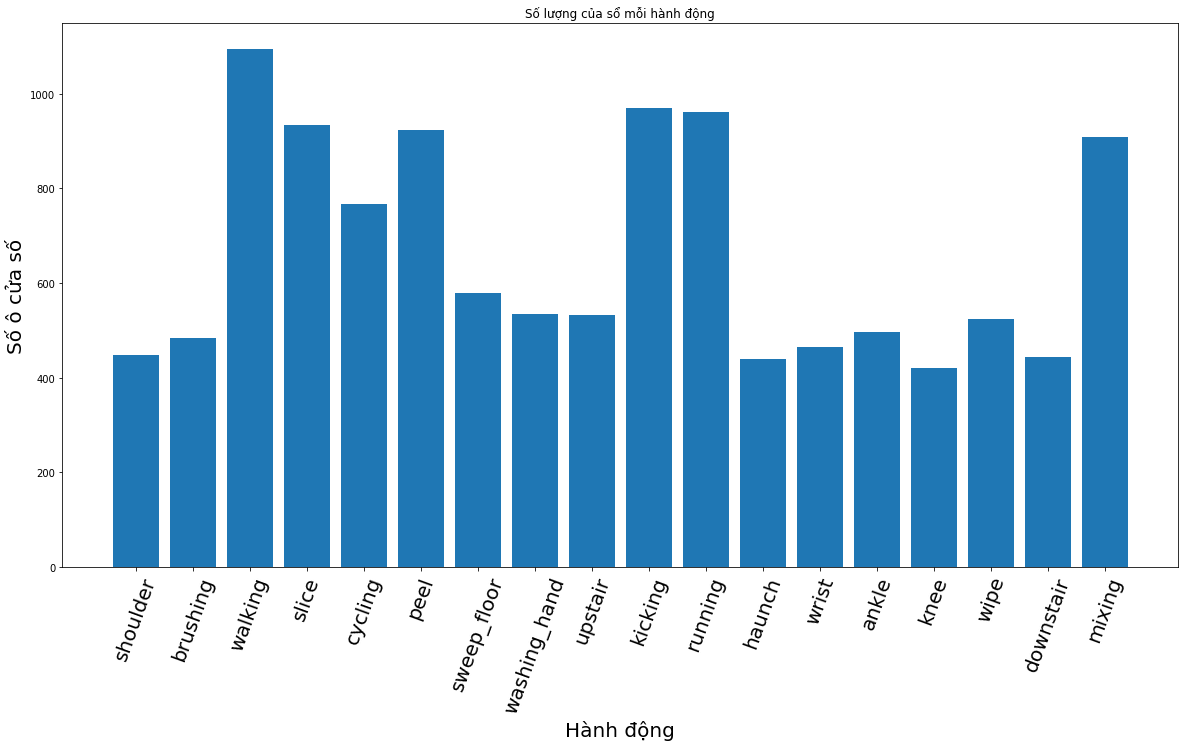

In [149]:
fig, ax = plt.subplots() 

# Get current size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
newlist = train_window_cnt
print [val[1] for val in newlist]
ax.set_title(u"Số lượng của sổ mỗi hành động")
ax.set_xlabel(u"Hành động", fontsize=20)
ax.set_ylabel(u"Số ô cửa số", fontsize=20)
plt.bar(range(len(newlist)), list(newlist.values()), align='center')
plt.xticks(range(len(newlist)), list(newlist.keys()), rotation=70, fontsize=20)

# plt.bar(range(len(top20)), [val[1] for val in top20], align='center')
# plt.xticks(range(len(top20)), [val[0] for val in top20])
# plt.xticks(rotation=70)
# plt.show()

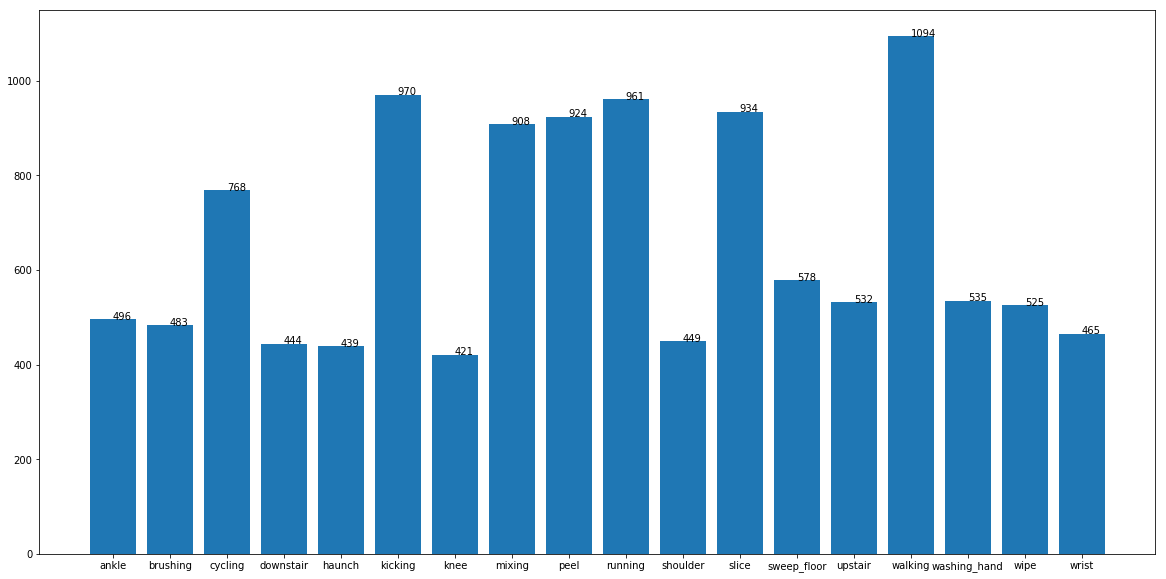

In [147]:
x = list(train_window_cnt.keys())
y = list(train_window_cnt.values())
plt.bar(x, y)
for a,b in zip(x, y):
    plt.text(a, b, str(b))
plt.show()